In [ ]:
!pip install --upgrade numpy

## Array value information

We had to do some troubleshooting so including this for posterity

In [1]:
import numpy as np
print(f"NumPy version THIS session is using: {np.__version__}")
import os
from google.colab import drive
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

save_path = '/content/drive/MyDrive/AAI511_ML/preprocessed_composer_data_v3.npz'

print(f"Inspecting arrays inside: {save_path}\n")

try:
    with zipfile.ZipFile(save_path) as zf:
        for name in zf.namelist():
            if not name.endswith('.npy'):
                continue

            with zf.open(name) as fp:
                # get the file format version
                version = np.lib.format.read_magic(fp)

                # Call the correct header function based on the version
                if version[0] == 1:
                    shape, fortran_order, dtype = np.lib.format.read_array_header_1_0(fp)
                elif version[0] == 2:
                    shape, fortran_order, dtype = np.lib.format.read_array_header_2_0(fp)
                else:
                    print(f"--> Array: '{name.replace('.npy', '')}' has an unsupported format version: {version}")
                    continue

                array_name = name.replace('.npy', '')
                print(f"--> Array: '{array_name}'")
                print(f"    Shape: {shape}")
                print(f"    Data Type (dtype): {dtype}")
                print("-" * 20)

except Exception as e:
    print(f"An error occurred while inspecting the file: {e}")

NumPy version THIS session is using: 2.0.2
Mounted at /content/drive
Inspecting arrays inside: /content/drive/MyDrive/AAI511_ML/preprocessed_composer_data_v3.npz

--> Array: 'network_input'
    Shape: (802691, 100, 1)
    Data Type (dtype): float64
--------------------
--> Array: 'network_output'
    Shape: (802691,)
    Data Type (dtype): int64
--------------------
--> Array: 'n_vocab'
    Shape: (1,)
    Data Type (dtype): int64
--------------------
--> Array: 'composer_map'
    Shape: ()
    Data Type (dtype): object
--------------------
--> Array: 'note_to_int'
    Shape: ()
    Data Type (dtype): object
--------------------


## Training

In [3]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the preprocessed data from your file
print(f"Loading preprocessed data from: {save_path}")
with np.load(save_path, allow_pickle=True) as data:
    network_input = data['network_input']
    network_output = data['network_output']
    composer_map = data['composer_map'].item()

print("Data loaded successfully!")

# Split data into training (80%) and validation (20%) sets
print("Splitting data into training and validation sets...")
X_train, X_val, y_train, y_val = train_test_split(
    network_input,
    network_output,
    test_size=0.2,
    random_state=42, # for reproducibility
    stratify=network_output # Ensures same class distribution in train/val sets
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Loading preprocessed data from: /content/drive/MyDrive/AAI511_ML/preprocessed_composer_data_v3.npz
Data loaded successfully!
Splitting data into training and validation sets...
Training samples: 642152
Validation samples: 160539


## Tensorflow Datasets

In [4]:
def create_optimized_dataset(features, labels, batch_size=64, is_training=True):
    """Creates an optimized tf.data.Dataset from numpy arrays."""
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    if is_training:
        dataset = dataset.shuffle(len(features), reshuffle_each_iteration=True)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Create the datasets
BATCH_SIZE = 128
train_dataset = create_optimized_dataset(X_train, y_train, batch_size=BATCH_SIZE)
validation_dataset = create_optimized_dataset(X_val, y_val, batch_size=BATCH_SIZE, is_training=False)

print("\nTensorFlow datasets created.")


TensorFlow datasets created.


## Define/Compile LSTM-CNN Model

In [5]:
def build_cnn_lstm_model(input_shape, num_classes):
    """Builds a hybrid CNN-LSTM model for sequence classification."""
    model = tf.keras.Sequential([
        # Input Layer
        tf.keras.layers.Input(shape=input_shape),

        # 1. CNN Block: To find local musical patterns
        tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='causal'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Dropout(0.2),

        # 2. LSTM Block: To learn long-term structure from the patterns
        tf.keras.layers.LSTM(256, return_sequences=False),
        tf.keras.layers.Dropout(0.3),

        # 3. Classification Head
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax') # Softmax for multi-class classification
    ])
    return model

# Get model parameters from the data
input_shape = X_train.shape[1:]
num_classes = len(np.unique(network_output))

# Build and compile the model
print("\nBuilding and compiling the model...")
model = build_cnn_lstm_model(input_shape=input_shape, num_classes=num_classes)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', # Use this for integer labels
    metrics=['accuracy']
)

model.summary()


Building and compiling the model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 100, 128)       │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,420 (1.63 MB)

 Trainable params: 428,420 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [6]:
# Add a callback to stop training early if performance plateaus
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Stop after 5 epochs with no improvement
    restore_best_weights=True # Restore the best model weights found
)

print("\nStarting model training...")
history = model.fit(
    train_dataset,
    epochs=50, # Set a high number, early stopping will find the best epoch
    validation_data=validation_dataset,
    callbacks=[early_stopping]
)



Starting model training...
Epoch 1/50
5017/5017 ━━━━━━━━━━━━━━━━━━━━ 62s 11ms/step - accuracy: 0.4378 - loss: 1.2240 - val_accuracy: 0.5512 - val_loss: 1.0520
Epoch 2/50
5017/5017 ━━━━━━━━━━━━━━━━━━━━ 59s 11ms/step - accuracy: 0.6041 - loss: 0.9482 - val_accuracy: 0.8276 - val_loss: 0.4588
Epoch 3/50
5017/5017 ━━━━━━━━━━━━━━━━━━━━ 59s 11ms/step - accuracy: 0.8396 - loss: 0.4295 - val_accuracy: 0.9477 - val_loss: 0.1488
Epoch 4/50
5017/5017 ━━━━━━━━━━━━━━━━━━━━ 59s 12ms/step - accuracy: 0.9379 - loss: 0.1775 - val_accuracy: 0.9792 - val_loss: 0.0629
Epoch 5/50
5017/5017 ━━━━━━━━━━━━━━━━━━━━ 59s 12ms/step - accuracy: 0.9644 - loss: 0.1036 - val_accuracy: 0.9890 - val_loss: 0.0334
Epoch 6/50
5017/5017 ━━━━━━━━━━━━━━━━━━━━ 59s 12ms/step - accuracy: 0.9766 - loss: 0.0696 - val_accuracy: 0.9938 - val_loss: 0.0197
Epoch 7/50
5017/5017 ━━━━━━━━━━━━━━━━━━━━ 59s 12ms/step - accuracy: 0.9820 - loss: 0.0548 - val_accuracy: 0.9955 - val_loss: 0.0131
Epoch 8/50
5017/5017 ━━━━━━━━━━━━━━━━━━━━ 59s 12

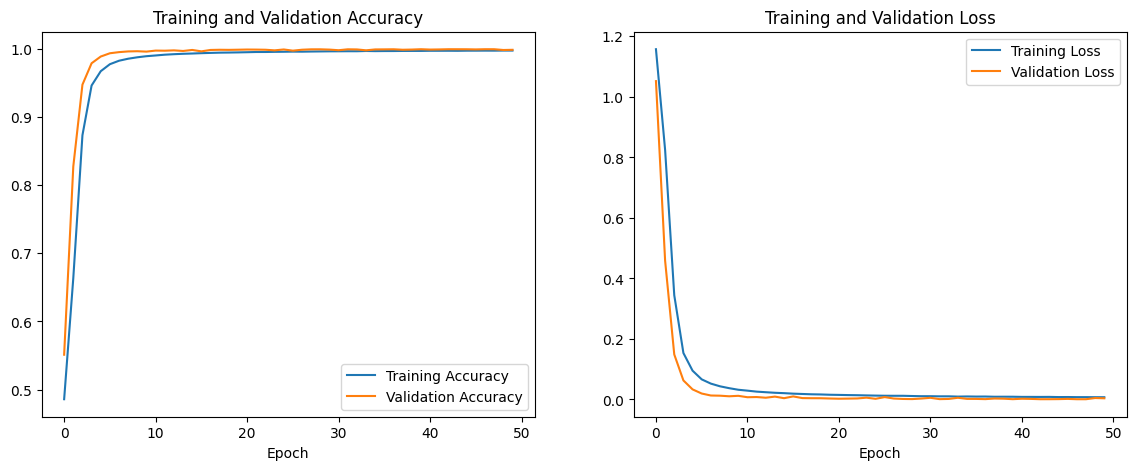

In [7]:
def plot_history(history):
    """Plots the training and validation accuracy and loss."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')

    plt.show()

plot_history(history)

## Metrics

In [8]:
from sklearn.metrics import classification_report
import numpy as np

print("Generating classification report for the validation set...")

# Get the model's predictions on the validation data
# The model outputs probabilities, so we use np.argmax to get the predicted class index
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get the true labels
y_true = y_val

# Get the composer names from the map for a more readable report
# Sort by the class index (0, 1, 2, ...) to match the report order
target_names = sorted(composer_map, key=composer_map.get)

# Generate and print the report
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=target_names))

Generating classification report for the validation set...
5017/5017 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step

--- Classification Report ---
              precision    recall  f1-score   support

        bach       1.00      1.00      1.00     35714
   beethoven       1.00      1.00      1.00     60499
      chopin       1.00      1.00      1.00     37711
      mozart       1.00      1.00      1.00     26615

    accuracy                           1.00    160539
   macro avg       1.00      1.00      1.00    160539
weighted avg       1.00      1.00      1.00    160539

